In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#parameters
in_file = '../../merge/reformatted_data_with_features.txt'
out_dir = 'ATAC_results'
metadata_file = '../../../../../metadata/MBC/merged_key_metadata.txt'
status_col = 'merged_updated_ER_status_binary'
n_iter = 1000

In [3]:
#import data
data = pd.read_csv(in_file, sep='\t')
data = data.set_index('sample')

#get features and exclude all other columns
features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('fft_10_magnitude'))]
data = data[features]
print('features',len(features))

#get metadata
metadata = pd.read_csv(metadata_file, sep='\t')
metadata = metadata.set_index('sample')
data = data.merge(metadata, left_index=True, right_index=True)
data['status'] = np.where(data[status_col]=='+',1,0)

#filter data
min_tfx = 0.05
min_cov = 0.1

#training data
data = data[(data['tumor_fraction']>=min_tfx) & (data['ulp_wgs_coverage']>=min_cov)]
print('total',len(data))
print(data[status_col].value_counts())

high_tfx = data[(data['tumor_fraction']>=0.1) & (data['ulp_wgs_coverage']>=min_cov)]
print('high tfx',len(high_tfx))
print(high_tfx[status_col].value_counts())
del(high_tfx)

low_tfx = data[(data['tumor_fraction']<0.1) & (data['ulp_wgs_coverage']>=min_cov)]
print('low tfx',len(low_tfx))
print(low_tfx[status_col].value_counts())
del(low_tfx)

data = data.sort_index()

features 12
total 254
+    132
-    122
Name: merged_updated_ER_status_binary, dtype: int64
high tfx 191
+    99
-    92
Name: merged_updated_ER_status_binary, dtype: int64
low tfx 63
+    33
-    30
Name: merged_updated_ER_status_binary, dtype: int64


In [4]:
features

Index(['central_cov_ER_neg_0_5_FC', 'central_cov_ER_neg_heme_0_5_FC',
       'central_cov_ER_pos_0_5_FC', 'central_cov_ER_pos_heme_0_5_FC',
       'fft_10_magnitude_ER_neg_0_5_FC', 'fft_10_magnitude_ER_neg_heme_0_5_FC',
       'fft_10_magnitude_ER_pos_0_5_FC', 'fft_10_magnitude_ER_pos_heme_0_5_FC',
       'mean_cov_ER_neg_0_5_FC', 'mean_cov_ER_neg_heme_0_5_FC',
       'mean_cov_ER_pos_0_5_FC', 'mean_cov_ER_pos_heme_0_5_FC'],
      dtype='object')

In [5]:
#view data
data.head()

,central_cov_ER_neg_0_5_FC,central_cov_ER_neg_heme_0_5_FC,central_cov_ER_pos_0_5_FC,central_cov_ER_pos_heme_0_5_FC,fft_10_magnitude_ER_neg_0_5_FC,fft_10_magnitude_ER_neg_heme_0_5_FC,fft_10_magnitude_ER_pos_0_5_FC,fft_10_magnitude_ER_pos_heme_0_5_FC,mean_cov_ER_neg_0_5_FC,mean_cov_ER_neg_heme_0_5_FC,...,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,status
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1041_1_ULP,1.046677,0.937325,0.951650,0.880745,0.804706,1.394362,0.814614,1.341675,1.006909,0.983537,...,same,+,+,-,+,gain,6746.0,1.0,1.0,1
MBC_1041_3_ULP,0.982260,0.994618,1.029097,0.941880,0.237202,2.300158,0.621023,2.115257,1.007673,0.986973,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1041_4_ULP,1.008080,0.941643,0.914425,0.915112,0.759014,0.982588,0.299798,2.855850,0.985060,0.978274,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1042_1_ULP,1.012633,0.938333,0.974047,0.889750,1.391274,2.003957,0.495576,3.480501,1.005824,1.000262,...,same,+,+,+,-,loss,2116.0,1.0,NaN,1
MBC_1042_2_ULP,1.016433,1.025027,0.876783,0.858495,0.700712,1.074858,0.361203,1.141419,1.000570,0.976233,...,same,+,+,+,-,loss,2116.0,1.0,1.0,1


In [6]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

central_cov_ER_neg_0_5_FC             -1.160926e-15
central_cov_ER_neg_heme_0_5_FC         3.524740e-15
central_cov_ER_pos_0_5_FC             -5.175213e-16
central_cov_ER_pos_heme_0_5_FC         4.965407e-16
fft_10_magnitude_ER_neg_0_5_FC         5.245148e-18
fft_10_magnitude_ER_neg_heme_0_5_FC   -1.302545e-16
fft_10_magnitude_ER_pos_0_5_FC        -9.790943e-17
fft_10_magnitude_ER_pos_heme_0_5_FC   -6.993531e-18
mean_cov_ER_neg_0_5_FC                -6.119340e-15
mean_cov_ER_neg_heme_0_5_FC           -8.846817e-16
mean_cov_ER_pos_0_5_FC                 6.853660e-16
mean_cov_ER_pos_heme_0_5_FC            7.357194e-15
dtype: float64

In [7]:
#bootstrapping
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

#loop for each iteration
countup = 0
for i in range(n_iter):
    if i%50==0:
        print(i,countup, time.time()-start_time)
    
    patients = pd.Series(data['patient_id'].unique())
    
    good_split = 0
    while good_split == 0:
        #bootstrap a training set with replacement
        training_ids = patients.sample(len(patients), replace = True, random_state = 100+countup)
                
        #get bootstrapped training set, if a patient ID is included in the training_ids set j times, include all samples from that patient j times
        training = pd.DataFrame()
        
        #group the training patient IDs by number of times they are observed in the bootstrapped training_ids
        for j,df in pd.DataFrame(training_ids.value_counts().rename('count')).groupby(by = 'count'):

            #identify the samples from this group of patients
            current_data = data[data['patient_id'].isin(df.index)]

            #copy the training samples so that they appear j times in training dataframe
            current_training = pd.DataFrame()
            for k in range(j):
                current_training = current_training.append(current_data)
            training = training.append(current_training)
        
        
        #the test set is all samples that aren't seen in the training data
        test = data[~(data.index.isin(training.index))]
        
        #check to make sure first time point low tumor fraction samples for both classes are included in the test set
        if len(test[(test['tumor_fraction']<.1) & (test['first_passing_sample']==1)]['status'].unique())!=2:
            print('skipping iteration',i)
            countup += 1
        else:
            good_split = 1
    
    #countup will get ahead of i if it has to skip bad train-test splits
    countup +=1
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state =100+countup) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    current_output['prediction']=pred
    current_output['accuracy'] = np.where(current_output['prediction']==current_output['status'],1,0)    
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)
    

probabilities = probabilities.merge(data[['status']], left_index=True, right_index=True)

0 0 0.0010008811950683594
50 50 11.842596769332886
100 100 22.64255690574646
150 150 32.57797193527222
200 200 43.591403007507324
250 250 53.36650896072388
300 300 62.96291494369507
350 350 72.9926028251648
400 400 83.23165273666382
450 450 93.86320209503174
500 500 103.75726008415222
550 550 113.08197093009949
600 600 122.49300503730774
650 650 132.18173098564148
700 700 141.69541788101196
skipping iteration 715
750 751 151.96591091156006
800 801 161.93871474266052
850 851 171.24457383155823
900 901 181.8187210559845
950 951 190.69191694259644


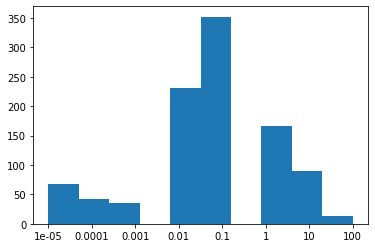

In [8]:
#export results
probabilities.to_csv(out_dir+'/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(out_dir+'/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(out_dir+'/coefs.txt', sep='\t')

plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(out_dir+'/cvals.pdf')

In [9]:
#print some key info

In [10]:
probabilities = probabilities.merge(data[['first_passing_sample','tumor_fraction']], left_index=True, right_index=True)

In [11]:
#high tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.8774002275612268

In [12]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.8443716211146528

In [13]:
#low tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.6385657267130127

In [ ]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

In [ ]:
#per patient accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'first_passing_sample','status']]
    current = current[(current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

In [ ]:
#per sample accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status']]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

# 